In [23]:
from __future__ import print_function
#from __future__ import division

import json
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import gzip
from scipy.misc import imsave
import time
import scipy.ndimage

from keras import backend as K
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Dropout

from keras.layers import *
from keras.layers.merge import concatenate
from keras.models import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras import losses

from keras.preprocessing.image import ImageDataGenerator

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


In [4]:
# PATH definition
initial_weights_path = "./models/initial_weights.hdf5"
final_weights_path = "./models/output_weights_batch_norm.hdf5"


# image dimension (array)
img_rows = 512
img_cols = 512

batch_size = 8

## Data loading - Data preprocessing

In [5]:
def preprocessor(input_img, img_rows, img_cols):
    """
    Resize input images to constants sizes
    :param input_img: numpy array of images
    :return: numpy array of preprocessed images
    """
    output_img = np.ndarray((input_img.shape[0], input_img.shape[1], img_rows, img_cols), dtype=np.uint8)
    
    for i in range(input_img.shape[0]):
        output_img[i, 0] = cv2.resize(input_img[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
    
    return output_img


def load_data(path_img, path_mask, img_rows, img_cols):
    """
    Load data from project path
    :return: [X, y] numpy arrays containing the [training, validation, test] data and their respective masks.
    """
    print("\nLoading data...\n")
    X = np.load(path_img)
    y = np.load(path_mask)

    X = preprocessor(X, img_rows, img_cols)
    y = preprocessor(y, img_rows, img_cols)

    X = X.astype('float32')

    mean = np.mean(X)  # mean for data centering
    std = np.std(X)  # std for data normalization

    X -= mean
    X /= std

    y = y.astype('float32')
    y /= 255.  # scale masks to [0, 1]
    return X, y

In [6]:
data_path = '../data/'

path_img_train = data_path + 'images_69.npy'
path_mask_train = data_path + 'masks_69.npy'

path_img_valid = data_path + 'images_valid_29.npy'
path_mask_valid = data_path + 'masks_valid_29.npy'

path_img_test = data_path + 'images_test_5.npy'
path_mask_test= data_path + 'masks_test_5.npy'


In [7]:
X_train, y_train = load_data(path_img_train, path_mask_train, img_rows, img_cols )
print("*************Xtrain.shape***********", y_train.shape)


X_valid, y_valid = load_data(path_img_valid, path_mask_valid, img_rows, img_cols)
print("*************Xvalid.shape***********", X_valid.shape)


X_test, y_test = load_data(path_img_test, path_mask_test, img_rows, img_cols)
print("*************Xtest.shape***********", X_test.shape)



Loading data...

('*************Xtrain.shape***********', (69, 1, 512, 512))

Loading data...

('*************Xvalid.shape***********', (29, 1, 512, 512))

Loading data...

('*************Xtest.shape***********', (5, 1, 512, 512))


In [8]:
X_valid = X_valid[:-2]
y_valid = y_valid[:-2]

X_test = X_valid[-2:]
y_test = y_valid[-2:]

print(X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)
print(X_test.shape)

((27, 1, 512, 512), (27, 1, 512, 512), (2, 1, 512, 512), (2, 1, 512, 512))
(2, 1, 512, 512)


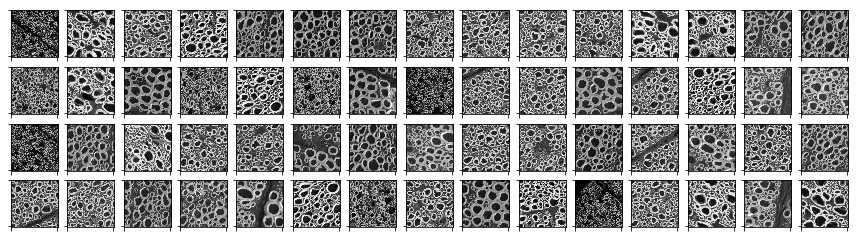

In [9]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i in range(max_images):
    img = X_train[i, 0, :, :]
    mask = y_train[i, 0, :, :]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="gray")
    ax.imshow(mask, alpha=0.3, cmap="gray")
    ax.set_yticklabels([])
    ax.set_xticklabels([])


## Build Model 

#### Metrics 

In [29]:
#### loss and metrics #####
def dice_coef(y_true, y_pred, smooth = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


"""def dice_coef(y_true, y_pred, smooth=1):

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)"""



def weighted_binary_crossentropy(y_true, y_pred):
        # Calculate the binary crossentropy
    b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
    weight_vector = y_true * 0.30 + (1. - y_true) * 0.70
    weighted_b_ce = weight_vector * b_ce

        # Return the mean error
    return K.mean(weighted_b_ce)

#### Unet

In [11]:
def unet_full_bn(dropout = True):
    inputs = Input((1, img_rows, img_cols))
    #conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)


    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)

   
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
    
    if dropout:
        pool4 = Dropout(0.5)(pool4)
   
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(conv5)

    if dropout:
        conv5 = Dropout(0.5)(conv5)    

    up6_interm = UpSampling2D(size=(2, 2))(conv5)
    
    up6 = concatenate([up6_interm, conv4], axis=1)

    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv6)
    batch6 = BatchNormalization(axis=1)(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    
    if dropout:
        up7 = Dropout(0.5)(up7)  
        
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv7)
    batch7 = BatchNormalization(axis=1)(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(batch7), conv2], axis=1)

    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv8)
    batch8 = BatchNormalization(axis=1)(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(batch8), conv1], axis=1)

    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation="sigmoid")(batch9)

    #model = Model(input=inputs, output=conv10)
    model = Model(outputs=conv10, inputs=inputs)

    #model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    #model.compile(optimizer=Adam(lr=1e-3), loss=losses.binary_crossentropy, metrics = [dice_coef])
    model.compile(optimizer=Adam(lr = learning_rate, decay=decay_rate), loss=weighted_binary_crossentropy, 
                  metrics = [dice_coef])

    return model



### Data Augmentation

In [12]:
### data augmentation ######
def data_generator():
    """
    :return: Keras data generator. Data augmentation parameters.
    """
    return ImageDataGenerator(
        fill_mode = fill_mode,
        rotation_range = rotation_range,
        horizontal_flip = horizontal_flip,
        vertical_flip = vertical_flip,
        rescale = rescale,
        zoom_range = zoom_range,
        channel_shift_range = channel_shift_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range)

In [13]:
fill_mode = 'reflect'
rotation_range= 10
horizontal_flip= True
vertical_flip = True
rescale = 0
zoom_range= 0
channel_shift_range = 0.1
width_shift_range = 0.1
height_shift_range = 0.1

In [16]:
# data augmentation
seed = 1

train_img_generator = data_generator().flow(X_train, seed = seed, batch_size = batch_size,  shuffle=False)
train_mask_generator = data_generator().flow(y_train, seed = seed, batch_size = batch_size, shuffle=False)

train_generator = zip(train_img_generator, train_mask_generator)




val_img_generator = data_generator().flow(X_valid, seed = seed, batch_size = batch_size, shuffle=False)
val_mask_generator = data_generator().flow(y_valid, seed = seed, batch_size = batch_size, shuffle=False)

val_generator = zip(val_img_generator, val_mask_generator)


In [ ]:
max_images = 16
grid_width = 8
grid_height = 1
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 10))
for i in range(8):
    img = train_generator[0][0][i, 0, :, :]
    mask = train_generator[0][1][i, 0, :, :]
    ax = axs[ i % grid_width]
    ax.imshow(img, cmap="gray")
    ax.set_yticklabels([])
    ax.set_xticklabels([])


fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 10))
for i in range(8):
    img = train_generator[0][0][i, 0, :, :]
    mask = train_generator[0][1][i, 0, :, :]
    ax = axs[ i % grid_width]
    ax.imshow(mask, cmap="gray")
    ax.set_yticklabels([])
    ax.set_xticklabels([])

## Training

In [15]:
K.set_image_dim_ordering('th')  # Theano dimension ordering in this code
smooth = 1.
Dropout.call = call

nb_initial_epochs = 300
apply_augmentation = True
nb_step_predictions = 20

learning_rate = 1e-3
decay_rate = learning_rate / nb_initial_epochs


apply_edt = False

In [14]:
#Override Dropout. Make it able at test time.
def call(self, inputs, training=None):
    if 0. < self.rate < 1.:
        noise_shape = self._get_noise_shape(inputs)
        def dropped_inputs():
            return K.dropout(inputs, self.rate, noise_shape,
                             seed=self.seed)
        if (training):
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        else:
            return K.in_test_phase(dropped_inputs, inputs, training=None)
    return inputs

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [ ]:
model = unet_full_bn(dropout = True)
reset_weights(model)
print(model.summary())

model_checkpoint = ModelCheckpoint(initial_weights_path, monitor='loss', save_best_only = True)


# if Data Augmentation
if apply_augmentation:
    timestamp = format(time.strftime('%m%d_%H%M_%S'))
    tensorboard = TensorBoard(log_dir = str("../logs/" + str(timestamp)))
    history = model.fit_generator(train_generator, 
                                  validation_data = (X_valid, y_valid),
                                  epochs = nb_initial_epochs, 
                                  verbose = 1,
                                  shuffle = True,
                                  steps_per_epoch=100, 
                                  #validation_steps= 5,
                                  callbacks = [tensorboard])
    model.save(final_weights_path)

    
# if No Data Augmentation
else:
    timestamp = format(time.strftime('%m%d_%H%M_%S'))
    tensorboard = TensorBoard(log_dir = str("../logs/" + str(timestamp)))
    history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid),
                            batch_size = batch_size, 
                            epochs = nb_initial_epochs,
                            verbose = 1, 
                            shuffle = True, 
                            callbacks = [tensorboard])
    model.save(final_weights_path)


In [ ]:
print("Saving model...\n")   
good_model_path = "./models/good_model_weights.hdf5"
model.save(good_model_path)

## Predict and Compute Uncertainty Map

In [17]:
def predict(data, model):
    """
    Data prediction for a given model
    :param data: input data to predict.
    :param model: unet model.
    :return: predictions.
    """
    return model.predict(data, verbose=0)

def compute_dice_coef(y_true, y_pred):
    """
    Computes the Dice-Coefficient of a prediction given its ground truth.
    :param y_true: Ground truth.
    :param y_pred: Prediction.
    :return: Dice-Coefficient value.
    """
    smooth = 1.  # smoothing value to deal zero denominators.
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)


def compute_uncertain(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: overall uncertainty (not map) .
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return np.sum(var * transform)

    else:
        return np.sum(np.var(X, axis=0))

def compute_uncertain_map(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: uncertainty map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return var * transform

    else:
        return np.var(X, axis=0)  

In [ ]:
# uncertainty computation

weights = good_model_path
modelUncertain = unet_full_bn(dropout = True)
modelUncertain.load_weights(weights)

uncertain_map = []
dice_coef_test = np.zeros(len(X_test))
dice = []

print("Computing log predictions ...\n")
predictions = predict(X_test, modelUncertain)

for threshold in np.arange(0.1, 1.1, 0.1):
    dice_coef_test = np.zeros(len(X_test))
    for i in range(len(X_test)):
        sample = X_test[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        dice_coef_test[i] = compute_dice_coef(y_test[i][0], sample_prediction)
        uncertain_map_i = compute_uncertain_map(sample, sample_prediction, modelUncertain)
        uncertain_map.append(uncertain_map_i)
    dice.append(np.mean(dice_coef_test))


    
uncertain_map_array = np.asarray(uncertain_map)
print(uncertain_map_array.shape)
print("Done")

In [ ]:
plt.plot(np.arange(0.1, 1.1, 0.1), dice, )
plt.ylabel("Dice Coeff")
plt.xlabel("Threshold value")
plt.grid()
plt.show()

In [ ]:
plt.hist(predictions[0].flatten())
plt.title("Prediction histogram")
plt.show()
plt.hist(y_test[0].flatten())
plt.title("Mask histogram")
plt.show()


In [ ]:
max_images = 5
grid_width = 5
grid_height = 4
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 15))
for i in range(max_images):
    img = X_test[i, 0, :, :]
    mask = y_test[i, 0, :, :]
    pred = predictions[i, 0, :, :]
    uncert = uncertain_map_array[i, :, :]
    
    ax = axs[0, i % grid_width]
    ax.imshow(img)
    ax = axs[1, i % grid_width]
    ax.imshow(mask)
    ax = axs[2, i % grid_width]
    ax.imshow(pred)
    ax = axs[3, i % grid_width]
    ax.imshow(uncert)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

In [ ]:
# Plot predictions and uncertainty map for 2 samples 

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(predictions[0][0,:,:])
plt.title("Prediction sample 1")
plt.subplot(222)
plt.imshow(uncertain_map_array[0])
plt.title("Uncertainty map sample 1")
plt.subplot(223)
plt.imshow(X_test[0][0,:,:])
plt.title("Sample 1")
plt.subplot(224)
plt.imshow(y_test[0][0,:,:])
plt.title("Ground Truth sample 1")
plt.tight_layout()
plt.show()

## Hyperparameters optimization

In [18]:

from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe


In [19]:
def data():
    X_train = X_train
    y_train=y_train
    X_valid = X_valid
    y_valid = y_valid
    return X_train, y_train, X_valid, y_valid

In [27]:
def create_model(X_train, y_train, X_valid, y_valid):
    """
    Model providing function:

    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
        
    """

    
    inputs = Input((1, img_rows, img_cols))
    #conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)


    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)

   
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
    
    if dropout:
        pool4 = Dropout(0.5)(pool4)
   
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(conv5)

    if dropout:
        conv5 = Dropout(0.5)(conv5)    

    up6_interm = UpSampling2D(size=(2, 2))(conv5)
    
    up6 = concatenate([up6_interm, conv4], axis=1)

    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv6)
    batch6 = BatchNormalization(axis=1)(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    
    if dropout:
        up7 = Dropout({{choice([0.3, 0.5])}})(up7)  
        
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv7)
    batch7 = BatchNormalization(axis=1)(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(batch7), conv2], axis=1)

    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv8)
    batch8 = BatchNormalization(axis=1)(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(batch8), conv1], axis=1)

    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation="sigmoid")(batch9)

    model = Model(outputs=conv10, inputs=inputs)

    model.compile(optimizer=Adam(lr = learning_rate, decay=decay_rate), loss=weighted_binary_crossentropy, 
                  metrics = [dice_coef])
    
    
    model.fit_generator(X_train, y_train, 
                        validation_data = (X_valid, y_valid),
                        epochs = 10, 
                        verbose = 1,
                        shuffle = True,
                        steps_per_epoch=2) 
                                  #validation_steps= 5,
                                  #callbacks = [tensorboard])


    score, dice = model.evaluate(X_valid, y_valid, verbose=0)
    print('Test accuracy:', dice)
    return {'loss': -dice, 'status': STATUS_OK, 'model': model}




In [28]:
if __name__ == '__main__':
    best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=5,
                                          trials=Trials(),
                                          notebook_name='uncertainty_scratch_1709')
    X_train, y_train, X_valid, y_valid = data()
    print("Evalutation of best performing model:")
    print(best_model.evaluate(X_valid, y_valid))
    print("Best performing model chosen hyper-parameters:")
    print(best_run)

SyntaxError: invalid syntax (<unknown>, line 781)

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

In [ ]:
# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(build_fn=unet_full_bn, verbose=1)

In [ ]:
# Create hyperparameter space
epochs = [5, 10]
batches = [5, 8]


# Create hyperparameter options
hyperparameters = dict(epochs=epochs, batch_size=batches)

In [ ]:
# Create grid search
grid = GridSearchCV(estimator=neural_network, param_grid=hyperparameters)

# Fit grid search
grid_result = grid.fit(X_train, y_train )